In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rioxarray as rioxr
import geopandas as gpd
import pandas as pd
import rasterio
import shapely
import os

#from shapely.geometry import shape
from shapely.geometry import Point

import pystac_client
import planetary_computer as pc

In [2]:
# accesing Azure storage using pystac client
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)

# ********* THIS NEEDS TO BE DYNAMIC, NOT HARDCODED *********
# ********* HERE I KNOW WHICH IMAGE TEHSE POINTS ARE IN ******
#campus point naip scene
itemid = 'ca_m_3411934_sw_11_060_20180722_20190209'
search = catalog.search(
    collections=["naip"],
    ids = itemid
)
item = list(search.get_items())[0]
# sign and open item
href = pc.sign(item.assets["image"].href)
ds = rasterio.open(href)
ds.crs

CRS.from_epsg(26911)

In [3]:
# fp = os.path.join(os.getcwd(),'3mlidar_over_campuspoint_naip_scene.tif')
# lidar2 = rioxr.open_rasterio(fp)

# fig, ax = plt.subplots(figsize = (6,6))
# lidar2.plot(ax=ax)

In [4]:
fp = os.path.join(os.getcwd(),'3mlidar_over_campuspoint_naip_scene.tif')

lidar = rasterio.open(fp)
lidar.crs

CRS.from_epsg(32610)

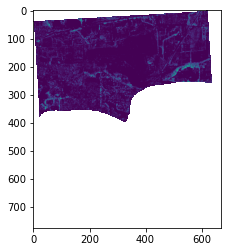

In [5]:
plt.imshow(lidar.read(1,masked=True))
plt.show()

In [6]:
fp = os.path.join(os.getcwd(),'aux_data','trainset_BIG.csv')
df = pd.read_csv(fp)
df.drop(['geometry','Unnamed: 0'],axis=1,inplace=True)

# recreate geometry column with shapely Points
xy = []
for x,y in zip(df.x,df.y):
    xy.append(Point(x,y))
df['geometry'] = xy
df.drop(['x','y'],axis=1,inplace=True)
df.head(3)

/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,r,g,b,nifr,iceplant,geometry
0,87,80,87,140,1,POINT (238502.9096209884 3810767.010170993)
1,85,81,84,149,1,POINT (238531.08502453016 3810765.502552128)
2,96,83,89,149,1,POINT (238514.12151877335 3810770.244742661)


In [7]:
pts = gpd.GeoDataFrame(df,crs=ds.crs)
pts = pts.to_crs(lidar.crs)
pts['xy'] = pts.geometry.apply(lambda p :(p.x, p.y)) #this is the format needed to sample 
pts.head(3)

,r,g,b,nifr,iceplant,geometry,xy
0,87,80,87,140,1,POINT (790036.615 3811611.935),"(790036.6152095036, 3811611.935235659)"
1,85,81,84,149,1,POINT (790064.836 3811612.097),"(790064.8358742013, 3811612.097478939)"
2,96,83,89,149,1,POINT (790047.618 3811615.828),"(790047.6181619561, 3811615.828344848)"


In [8]:
sample = lidar.sample(pts.xy.to_list())

samples = []
for x in sample:
    samples.append(x[0])
    
pts['lidar']=samples   
pts.head(3)

,r,g,b,nifr,iceplant,geometry,xy,lidar
0,87,80,87,140,1,POINT (790036.615 3811611.935),"(790036.6152095036, 3811611.935235659)",3
1,85,81,84,149,1,POINT (790064.836 3811612.097),"(790064.8358742013, 3811612.097478939)",2
2,96,83,89,149,1,POINT (790047.618 3811615.828),"(790047.6181619561, 3811615.828344848)",2


In [ ]:
# get DataFrame back to NAIP scene crs
pts = pts.to_crs(ds.crs)
pts.drop('xy',axis=1,inplace=True)


In [10]:
pts = pts[['r','g','b','nifr','lidar','iceplant','geometry']]
pts.head(3)

,r,g,b,nifr,lidar,iceplant,geometry
0,87,80,87,140,3,1,POINT (238502.910 3810767.010)
1,85,81,84,149,2,1,POINT (238531.085 3810765.503)
2,96,83,89,149,2,1,POINT (238514.122 3810770.245)
3,93,89,86,161,2,1,POINT (238494.772 3810776.858)
4,84,78,85,135,3,1,POINT (238504.770 3810767.611)
...,...,...,...,...,...,...,...
4784,87,83,83,159,0,1,POINT (238528.649 3810823.989)
4785,86,84,84,164,0,1,POINT (238523.834 3810824.089)
4786,84,82,85,147,0,1,POINT (238526.323 3810826.966)
4787,92,81,85,151,0,1,POINT (238528.572 3810829.298)


In [12]:
pts.to_csv(os.path.join(os.getcwd(),'aux_data','trainset_BIG_w_lidar','trainset_BIG_w_lidar.csv'))
pts.to_file(os.path.join(os.getcwd(),'aux_data','trainset_BIG_w_lidar','trainset_BIG_w_lidar.shp'))

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [13]:
fp = os.path.join(os.getcwd(),'aux_data','trainset_non_iceplant_vegetation.csv')
df = pd.read_csv(fp)
df.drop(['geometry','Unnamed: 0'],axis=1,inplace=True)

# recreate geometry column with shapely Points
xy = []
for x,y in zip(df.x,df.y):
    xy.append(Point(x,y))
df['geometry'] = xy
df.drop(['x','y'],axis=1,inplace=True)
df.head(3)

/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,r,g,b,nifr,iceplant,geometry
0,163,144,116,183,0,POINT (237140.55244983404 3814526.1699873866)
1,114,103,95,140,0,POINT (236884.1208763368 3814547.904989664)
2,59,67,69,137,0,POINT (237192.64798213769 3814447.7745699394)


In [14]:
pts = gpd.GeoDataFrame(df,crs=ds.crs)
pts = pts.to_crs(lidar.crs)
pts['xy'] = pts.geometry.apply(lambda p :(p.x, p.y)) #this is the format needed to sample 
pts.head(3)

,r,g,b,nifr,iceplant,geometry,xy
0,163,144,116,183,0,POINT (788453.812 3815284.554),"(788453.8123549668, 3815284.553521687)"
1,114,103,95,140,0,POINT (788196.500 3815291.065),"(788196.4999055057, 3815291.065491781)"
2,59,67,69,137,0,POINT (788510.469 3815209.367),"(788510.4692361669, 3815209.367231002)"


In [15]:
sample = lidar.sample(pts.xy.to_list())

samples = []
for x in sample:
    samples.append(x[0])
    
pts['lidar']=samples   
pts.head(3)

,r,g,b,nifr,iceplant,geometry,xy,lidar
0,163,144,116,183,0,POINT (788453.812 3815284.554),"(788453.8123549668, 3815284.553521687)",0
1,114,103,95,140,0,POINT (788196.500 3815291.065),"(788196.4999055057, 3815291.065491781)",3
2,59,67,69,137,0,POINT (788510.469 3815209.367),"(788510.4692361669, 3815209.367231002)",19


In [16]:
# get DataFrame back to NAIP scene crs
pts = pts.to_crs(ds.crs)
pts.drop('xy',axis=1,inplace=True)

In [17]:
pts = pts[['r','g','b','nifr','lidar','iceplant','geometry']]
pts.head(3)

,r,g,b,nifr,lidar,iceplant,geometry
0,163,144,116,183,0,0,POINT (237140.552 3814526.170)
1,114,103,95,140,3,0,POINT (236884.121 3814547.905)
2,59,67,69,137,19,0,POINT (237192.648 3814447.775)


In [18]:
pts.to_csv(os.path.join(os.getcwd(),'aux_data','trainset_non_iceplant_vegetation_w_lidar','trainset_non_iceplant_vegetation_w_lidar.csv'))
pts.to_file(os.path.join(os.getcwd(),'aux_data','trainset_non_iceplant_vegetation_w_lidar','trainset_non_iceplant_vegetation_w_lidar.shp'))

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
